In [58]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.signal import find_peaks

In [12]:
def getPMDIRR(filename):
    df_pmdi = pd.read_csv(filename)
    df_pmdi['datetime'] = df_pmdi['TIME'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M:%S'))
    df_pmdi['epoch'] = df_pmdi['datetime'].apply(lambda x: datetime.datetime.timestamp(x))
    # print(df_pmdi['RESP'].unique())
    df_pmdi = df_pmdi.drop(df_pmdi[df_pmdi['RESP'] == '^^'].index)
    df_pmdi['RR'] = df_pmdi['RESP'].apply(lambda x: float(x))
    return df_pmdi[['epoch', 'RR', 'datetime']]

In [49]:
def getDSTRR(filename):
    df_dst = pd.read_csv(filename)
    df_dst.drop(index=df_dst.index[0], axis=0, inplace=True)
    df_dst.drop_duplicates(inplace=True)
    df_dst.reset_index(drop=True, inplace=True)
    df_dst['datetime'] = df_dst['Timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    return df_dst

In [14]:
def selectFile():
    root = Tk()
    root.withdraw()
    root.overrideredirect(True)
    root.geometry('0x0+0+0')
    root.deiconify()
    root.lift()
    root.focus_force()
    filename = askopenfilename(filetypes=[("Comma Seperated Values File", ".csv")], parent=root)
    root.destroy()
    if not filename:
        sys.exit("No file selected")

    return filename

           epoch    RR            datetime
0   1.546882e+09  35.0 2019-01-07 12:20:59
1   1.546882e+09  43.0 2019-01-07 12:21:00
2   1.546882e+09  43.0 2019-01-07 12:21:01
3   1.546882e+09  47.0 2019-01-07 12:21:02
4   1.546882e+09  52.0 2019-01-07 12:21:03
5   1.546882e+09  56.0 2019-01-07 12:21:04
6   1.546882e+09  61.0 2019-01-07 12:21:05
7   1.546882e+09  61.0 2019-01-07 12:21:06
8   1.546882e+09  58.0 2019-01-07 12:21:07
9   1.546882e+09  60.0 2019-01-07 12:21:08
10  1.546882e+09  66.0 2019-01-07 12:21:09
11  1.546882e+09  76.0 2019-01-07 12:21:10
12  1.546882e+09  77.0 2019-01-07 12:21:12
13  1.546882e+09  76.0 2019-01-07 12:21:13
14  1.546882e+09  77.0 2019-01-07 12:21:14
15  1.546882e+09  76.0 2019-01-07 12:21:15
16  1.546882e+09  75.0 2019-01-07 12:21:16
17  1.546882e+09  72.0 2019-01-07 12:21:17
18  1.546882e+09  69.0 2019-01-07 12:21:18
19  1.546882e+09  67.0 2019-01-07 12:21:19
20  1.546882e+09  66.0 2019-01-07 12:21:20
21  1.546882e+09  66.0 2019-01-07 12:21:21
22  1.54688

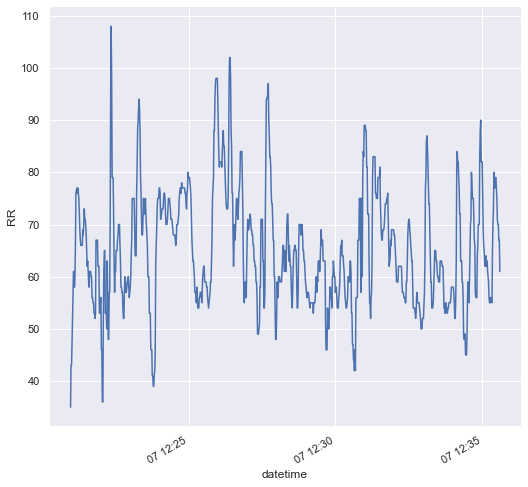

In [15]:
df_PMDIRR = getPMDIRR(selectFile())
df_test = df_PMDIRR.head(32)
print(df_test)

In [34]:
df_PMDIRR_seg = df_PMDIRR.loc[df_PMDIRR['datetime'] >= datetime.datetime.fromisoformat('2019-01-07T12:23:40')]
df_PMDIRR_seg = df_PMDIRR_seg.loc[df_PMDIRR_seg['datetime'] <= datetime.datetime.fromisoformat('2019-01-07T12:25:03')]

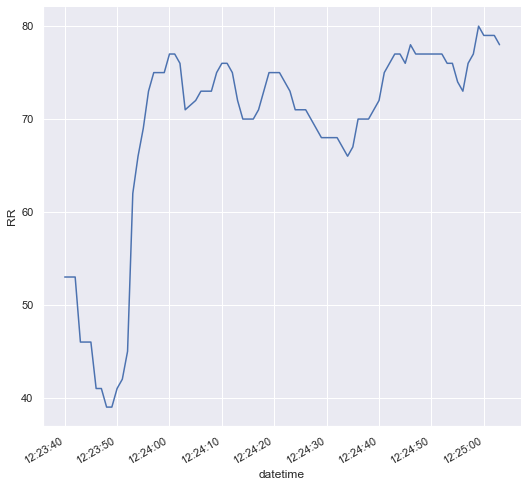

In [35]:
sns.set_theme(style='darkgrid')
g = sns.relplot(x="datetime", y="RR", kind="line", data=df_PMDIRR_seg, height=7.5)
g.figure.autofmt_xdate()

In [50]:
df_DSTRR = getDSTRR(selectFile())

In [51]:
df_DSTRR_seg = df_DSTRR.loc[df_DSTRR['datetime'] >= datetime.datetime.fromisoformat('2019-01-07T12:23:40')]
print(df_DSTRR_seg.iloc[-1])

Timestamp     2019-01-07 12:25:03
Mean Depth            4211.527161
datetime      2019-01-07 12:25:03
Name: 9145, dtype: object


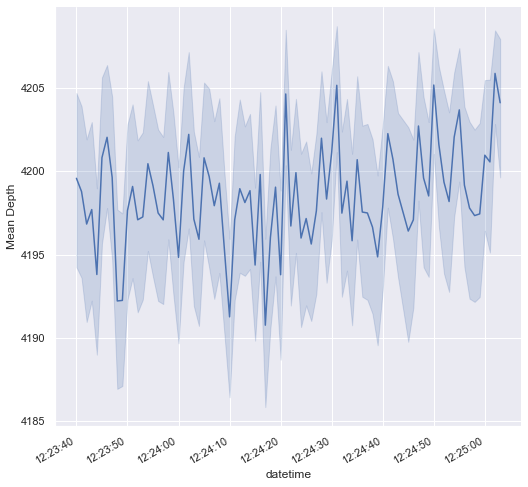

In [52]:
sns.set_theme(style='darkgrid')
g = sns.relplot(x='datetime', y='Mean Depth', kind='line', data=df_DSTRR_seg, height=7.5)
g.figure.autofmt_xdate()

In [77]:
# Find RR over window of 10 seconds to match PMDI data
# Since framerate is 30 FPS, each second contains 30 samples
# Each peak needs to be a minimum of 23 samples away from the last
# Works out to a maximum BPM of 138 (Neonatal limit is around 135 BPM)
def estRR_timeDomain(df, window=300):
    estimatedRRs = []
    timestamps = []
    for window in df.rolling(window):
        peaks, peak_props = find_peaks(window['Mean Depth'], distance=23)
        if len(peaks) > 1:
            firstPeak = window.iloc[peaks[0]]
            lastPeak = window.iloc[peaks[-1]]
            estRR = (((len(peaks) - 1) * 30) / (lastPeak.name - firstPeak.name)) * 60
            estimatedRRs.append(estRR)
            timestamps.append(window.iloc[-1]['datetime'])

    d = {'timestamps': timestamps, 'RR': estimatedRRs}
    df_estimatedRRs = pd.DataFrame(d)
    return df_estimatedRRs

df_est = estRR_timeDomain(df_DSTRR)
df_est.drop_duplicates(inplace=True)
df_est.reset_index(drop=True, inplace=True)


print(df_est.head())

           timestamps         RR
0 2019-01-07 12:19:53  75.000000
1 2019-01-07 12:19:54  75.000000
2 2019-01-07 12:19:54  66.666667
3 2019-01-07 12:19:55  66.666667
4 2019-01-07 12:19:55  76.056338


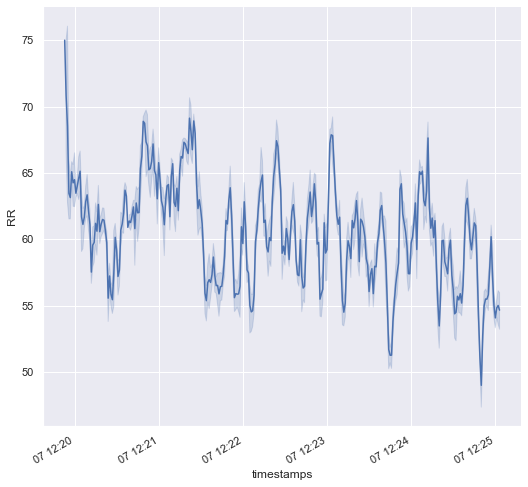

In [78]:
g = sns.relplot(x='timestamps', y='RR', kind='line', data=df_est, height=7.5)
g.figure.autofmt_xdate()

In [79]:
df_est.describe()

,RR
count,1569.000000
mean,60.413194
std,4.123187
min,45.161290
25%,57.446809
50%,60.810811
75%,63.157895
max,76.056338


In [80]:
df_PMDIRR_seg.describe()

,epoch,RR
count,8.000000e+01,80.00000
mean,1.546882e+09,68.96250
std,2.431272e+01,11.13376
min,1.546882e+09,39.00000
25%,1.546882e+09,68.00000
50%,1.546882e+09,73.00000
75%,1.546882e+09,76.00000
max,1.546882e+09,80.00000
